### Adding homeport from vessel 

In [33]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from shapely.geometry import Point
import geopandas as gpd
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor




In [34]:
train = pd.read_csv('data/datasets/ais_train.csv', sep='|')
train['time'] = pd.to_datetime(train['time'])
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

# Print the columns with missing values
# missing_columns = missing_values[missing_values > 0].index.tolist()
# print("Columns with missing values:", missing_columns)

train.head()

test = pd.read_csv('data/datasets/ais_test.csv', sep=',')
test['time'] = pd.to_datetime(test['time'])
test.head()

vessels = pd.read_csv('data/datasets/vessels.csv', sep='|')
vessels.head()

ports = pd.read_csv('data/datasets/ports.csv', sep='|')
ports.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  object        
 10  portId     1520450 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 127.7+ MB
Number of missing values in each column:
 time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [35]:
port_id_mapping = {port_id: idx for idx, port_id in enumerate(train['portId'].unique())}
train['portId'] = train['portId'].map(port_id_mapping)
ports['portId'] = ports['portId'].map(port_id_mapping)

vessel_id_mapping = {vessel_id: idx for idx, vessel_id in enumerate(train['vesselId'].unique())}
train['vesselId'] = train['vesselId'].map(vessel_id_mapping)
vessels['vesselId'] = vessels['vesselId'].map(vessel_id_mapping)
test['vesselId'] = test['vesselId'].map(vessel_id_mapping)

shipping_line_id_mapping = {shipping_line_id: idx for idx, shipping_line_id in enumerate(vessels['shippingLineId'].unique())}
vessels['shippingLineId'] = vessels['shippingLineId'].map(shipping_line_id_mapping)

In [36]:
vessels.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,0,599.0,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,1,65.0,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,2,640.0,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,3,255.0,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,4,68.0,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018


In [37]:


train = train.merge(ports[['portId', 'latitude', 'longitude']], how='left', left_on='portId', right_on='portId', suffixes=('', '_port'))
train.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000


Add a 'favourite port', don't think this helped 

In [38]:


# # Count the frequency of each port visit for each vessel
# port_visits = train.groupby(['vesselId', 'portId']).size().reset_index(name='visit_count')

# # Sort by vesselId and visit_count to see the most visited ports
# sorted_port_visits = port_visits.sort_values(by=['vesselId', 'visit_count'], ascending=[True, False])

# favorite_ports = sorted_port_visits.groupby('vesselId').first().reset_index()
# favorite_ports = favorite_ports[['vesselId', 'portId']]
# favorite_ports.columns = ['vesselId', 'favorite_port']

# # Merge favorite_ports with train based on vesselId
# train = train.merge(favorite_ports, on='vesselId', how='left')
# # Display the result
# train.head()

In [39]:
train = train.merge(vessels[['vesselId', 'length', 'shippingLineId', 'maxSpeed', 'breadth']], on='vesselId', how='left')
train['vessel_deep_sea'] = np.where(train['length'] > 200, 1, 0)

num_maxSpeed_nan = train['breadth'].isna().sum()
print(f"Number of NaN values in maxSpeed: {num_maxSpeed_nan}")
train.head()

Number of NaN values in maxSpeed: 14949


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port,length,shippingLineId,maxSpeed,breadth,vessel_deep_sea
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889,199.00,9,NaN,32.00,0
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000,199.97,6,22.5,32.26,0
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889,199.00,14,NaN,32.00,0
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444,199.00,5,NaN,32.00,0
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000,199.95,6,22.4,32.20,0


Add if the vessel is on land or in ocean 
- needed to download the fila locally and not through Git 

In [40]:
# Define the base directory dynamically
base_dir = Path.home() / 'ml'/'data' / 'datasets'

MAP_LAND_PATH = base_dir / 'ne_10m_land.zip'
MAP_OCEAN_PATH = base_dir / 'ne_10m_ocean.zip'

land_world = gpd.read_file(MAP_LAND_PATH)
ocean_world = gpd.read_file(MAP_OCEAN_PATH)

In [41]:

# Function to create a point from latitude and longitude
def create_point(lat, lon):
    return Point(lon, lat)  # Note: Point(lon, lat)

# Function to process each batch and check if points are in the ocean
def process_batch(batch, ocean_world):
    # Create a GeoDataFrame for the batch
    batch = batch.copy()
    batch['geometry'] = batch.apply(lambda row: create_point(row['latitude'], row['longitude']), axis=1)
    ais_geo_batch = gpd.GeoDataFrame(batch, geometry='geometry', crs="EPSG:4326")
    
    # Perform spatial join to check if points are in the ocean
    ais_ocean_batch = gpd.sjoin(ais_geo_batch, ocean_world, how="left", predicate='intersects')  
    
    # Create 'in_ocean' column: 1 if in ocean, 0 if not
    ais_ocean_batch['in_ocean'] = ais_ocean_batch.index_right.notnull().astype(int)
    
    return ais_ocean_batch

# Prepare sample data from ais DataFrame
ais_sample = train[['latitude', 'longitude', 'vesselId', 'time']]

# Function to process the AIS data in batches and update the original DataFrame
def process_in_batches(ais_sample, ocean_world, batch_size):
    ais_sample = ais_sample.copy()  # Ensure we're not modifying the original ais_sample
    num_batches = len(ais_sample) // batch_size + 1
    
    for i in range(num_batches):
        batch = ais_sample.iloc[i*batch_size:(i+1)*batch_size]
        print(f"Processing batch {i + 1}/{num_batches}")
        
        # Process the current batch
        ais_ocean_batch = process_batch(batch, ocean_world)
        
        # Update the 'in_ocean' column in the original DataFrame (ais_sample)
        ais_sample.loc[batch.index, 'in_ocean'] = ais_ocean_batch['in_ocean'].values
    
    return ais_sample

# Parameters
batch_size = 10000  # Adjust batch size based on available memory

# Process the AIS data in batches and update the original DataFrame
ais_ocean = process_in_batches(ais_sample, ocean_world, batch_size)

# Display the updated AIS DataFrame with the new 'in_ocean' column
print("Updated AIS DataFrame with 'in_ocean' column:")
# print(ais_ocean[['vesselId', 'time', 'latitude', 'longitude', 'in_ocean']].head())

# Optionally merge the updated sample back into the original AIS DataFrame
# ais = ais.merge(ais_sample[['vesselId', 'time', 'in_ocean']], on=['vesselId', 'time'], how='left')

ais_ocean['time'] = pd.to_datetime(ais_ocean['time'])

ais_ocean.head()

Processing batch 1/153
Processing batch 2/153
Processing batch 3/153
Processing batch 4/153
Processing batch 5/153
Processing batch 6/153
Processing batch 7/153
Processing batch 8/153
Processing batch 9/153
Processing batch 10/153
Processing batch 11/153
Processing batch 12/153
Processing batch 13/153
Processing batch 14/153
Processing batch 15/153
Processing batch 16/153
Processing batch 17/153
Processing batch 18/153
Processing batch 19/153
Processing batch 20/153
Processing batch 21/153
Processing batch 22/153
Processing batch 23/153
Processing batch 24/153
Processing batch 25/153
Processing batch 26/153
Processing batch 27/153
Processing batch 28/153
Processing batch 29/153
Processing batch 30/153
Processing batch 31/153
Processing batch 32/153
Processing batch 33/153
Processing batch 34/153
Processing batch 35/153
Processing batch 36/153
Processing batch 37/153
Processing batch 38/153
Processing batch 39/153
Processing batch 40/153
Processing batch 41/153
Processing batch 42/153
P

,latitude,longitude,vesselId,time,in_ocean
0,-34.74370,-57.85130,0,2024-01-01 00:00:25,1.0
1,8.89440,-79.47939,1,2024-01-01 00:00:36,1.0
2,39.19065,-76.47567,2,2024-01-01 00:01:45,1.0
3,-34.41189,151.02067,3,2024-01-01 00:03:11,1.0
4,35.88379,-5.91636,4,2024-01-01 00:03:51,1.0


In [42]:
# Calculate the number of times each vessel is on land
train = train.merge(ais_ocean[['vesselId', 'time', 'in_ocean']], on=['vesselId', 'time'], how='left')

vessels_on_land = train[train['in_ocean'] == 0].groupby('vesselId').size().reset_index(name='on_land_count')

# Create a reverse mapping to get the original vesselId from the integer indices
reverse_vessel_id_mapping = {idx: vessel_id for vessel_id, idx in vessel_id_mapping.items()}

# Use this reverse mapping to get the original vesselId for vessels_on_land
vessels_on_land['original_vesselId'] = vessels_on_land['vesselId'].map(reverse_vessel_id_mapping)

# Sort the vessels by the number of times they are on land in descending order
vessels_on_land_sorted = vessels_on_land.sort_values(by='on_land_count', ascending=False)

# Calculate the total count of each vessel in the original train dataframe
total_counts = train['vesselId'].value_counts().reset_index()
total_counts.columns = ['vesselId', 'total_count']

# Merge total counts with vessels_on_land to calculate percentage
vessels_on_land_sorted = vessels_on_land_sorted.merge(total_counts, on='vesselId')

# Calculate the percentage of time each vessel is on land
vessels_on_land_sorted['on_land_percentage'] = (vessels_on_land_sorted['on_land_count'] / vessels_on_land_sorted['total_count']) * 100

# Sort the vessels by on_land_percentage in descending order
vessels_on_land_sorted = vessels_on_land_sorted.sort_values(by='on_land_percentage', ascending=False)

# Display the top vessels that are most on land by percentage
print(vessels_on_land_sorted[['original_vesselId', 'on_land_count', 'total_count', 'on_land_percentage']].head())


            original_vesselId  on_land_count  total_count  on_land_percentage
542  61e9f3c6b937134a3c4bfed5            130          160           81.250000
4    61e9f46ab937134a3c4c02a1           4501         5825           77.270386
5    61e9f464b937134a3c4c0263           3999         5761           69.415032
2    61e9f415b937134a3c4c0065           4675         6778           68.973148
1    61e9f466b937134a3c4c0275           4814         7003           68.741968


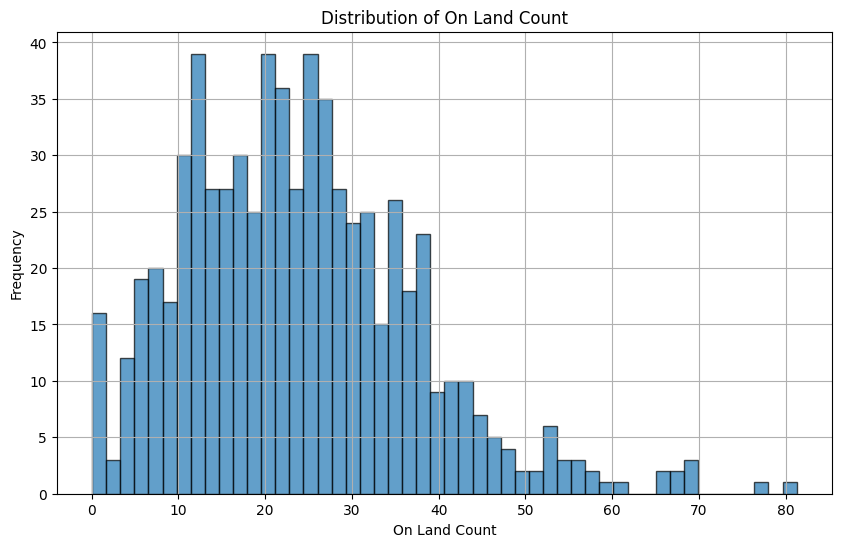

In [43]:
import matplotlib.pyplot as plt

# Plot the distribution of on_land_count
plt.figure(figsize=(10, 6))
plt.hist(vessels_on_land_sorted['on_land_percentage'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of On Land Count')
plt.xlabel('On Land Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [44]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    r = 6371  # Radius of Earth in kilometers
    return r * c  # Distance in kilometers

### Feature engineering 

In [46]:
def feature_engineering(train, ports):
    train = train.copy()
    features = pd.DataFrame()

    train = train.sort_values(by=['vesselId', 'time'])
    # Add the columns vesselId, time, latitude, longitude, cog and sog to the features from train
    features['vesselId'] = train['vesselId']
    features['time'] = train['time']
    features['latitude'] = train['latitude']
    features['longitude'] = train['longitude']
    features['latitude_port'] = train['latitude_port']
    features['longitude_port'] = train['longitude_port']    
    features['cog'] = train['cog']
    # features['sog'] = train['sog']
    features['in_ocean'] = train['in_ocean']

    # Create a new binary column for 'under_way' based on the navstat column in train. 
    # 1 if navstat is 0 or 8, 0 otherwise
    features['under_way'] = train['navstat'].isin([0, 8]).astype(int)

    train = train.sort_values(by=['vesselId', 'time'])
    features['speed'] = train.groupby('vesselId').apply(
        lambda x: np.sqrt((x['latitude'].diff()**2 + x['longitude'].diff()**2) / (x['time'].diff().dt.total_seconds()**2))
    ).reset_index(drop=True)

    # Rolling mean of speed over the last 6 observations
    features['rolling_speed_mean'] = features.groupby('vesselId')['speed'].transform(lambda x: x.rolling(window=6, min_periods=1).mean())

    # Rolling median of speed over the last 6 observations
    features['rolling_speed_median'] = features.groupby('vesselId')['speed'].transform(lambda x: x.rolling(window=6, min_periods=1).median())

    # Rolling count of movements over the last 6 observations
    features['rolling_movement_count'] = features.groupby('vesselId')['under_way'].transform(lambda x: x.rolling(window=6, min_periods=1).sum())

    # features['distance_to_nearest_port'] = features.apply(
    #     lambda row: min(haversine(row['latitude'], row['longitude'], port_lat, port_lon) for port_lat, port_lon in zip(ports['latitude'], ports['longitude'])),
    #     axis=1
    # )

    # features['time_spent_on_land'] = features.groupby('vesselId')['under_way'].apply(
    #     lambda x: ((x == 0) & (features['in_ocean'] == 0)).rolling(window=6, min_periods=1).sum()
    # ).reset_index(drop=True)
    # Time since last movement
    features['time_since_last_movement'] = train.groupby('vesselId')['time'].diff().dt.total_seconds().fillna(0)


    # Dropping NaN values after the rolling operations
    features = features.dropna()
    # Adding the columns latitude_1 (last seen latitude) and longitude_1 (last senn longitude)
    # to the features from train. For each vessel
    # Also adding time_1 (time difference from current time to last seen time)
    features['latitude_1'] = train.groupby('vesselId')['latitude'].shift(1)
    features['longitude_1'] = train.groupby('vesselId')['longitude'].shift(1)
    features['time_1'] = train.groupby('vesselId')['time'].diff().dt.total_seconds()

    # Adding the columns latitude_2 (second last seen latitude) and longitude_2 (second last seen longitude)
    # to the features from train. For each vessel
    # Also adding time_2 (time difference from current time to second last seen time)
    features['latitude_2'] = train.groupby('vesselId')['latitude'].shift(2)
    features['longitude_2'] = train.groupby('vesselId')['longitude'].shift(2)
    features['time_2'] = train.groupby('vesselId')['time'].diff(2).dt.total_seconds()

    # Adding the columns latitude_3 (third last seen latitude) and longitude_3 (third last seen longitude)
    # to the features from train. For each vessel
    # Also adding time_3 (time difference from current time to third last seen time)
    features['latitude_3'] = train.groupby('vesselId')['latitude'].shift(3)
    features['longitude_3'] = train.groupby('vesselId')['longitude'].shift(3)
    features['time_3'] = train.groupby('vesselId')['time'].diff(3).dt.total_seconds()


    # Dropping the rows with NaN values
    features = features.dropna()

    # Split the time column into month, day, hour, minute and second columns
    features['month'] = train['time'].dt.month
    features['day'] = train['time'].dt.day
    features['hour'] = train['time'].dt.hour
    features['minute'] = train['time'].dt.minute
    # features['second'] = train['time'].dt.second

    features['month_sin'] = np.sin(2 * np.pi * features['month']/12)
    features['month_cos'] = np.cos(2 * np.pi * features['month']/12)
    features['day_sin'] = np.sin(2 * np.pi * features['day']/31)
    features['day_cos'] = np.cos(2 * np.pi * features['day']/31)

    # features['favorite_port'] = train['favorite_port']  
    features['vessel_deep_sea'] = train['vessel_deep_sea']
    # features['shippingLineId'] = train['shippingLineId']
    features['length'] = train['length']
    # features['portId'] = train['portId']
    
    
    # features['distance_to_port'] = haversine(features['latitude'], features['longitude'], features['latitude_port'], features['longitude_port'])
    # # Group by vesselId and time to ensure the features are calculated correctly
    # features = features.groupby(['vesselId', 'time']).first().reset_index()
    # features['rolling_distance_mean'] = features.groupby('vesselId')['distance_to_port'].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
    # features['rolling_distance_sum'] = features.groupby('vesselId')['distance_to_port'].transform(lambda x: x.rolling(window=6, min_periods=1).sum())

    

    # # Create a flag if the rolling distance has been increasing over the last 6 values
    # features['rolling_distance_increasing'] = features.groupby('vesselId')['rolling_distance_mean'].transform(lambda x: x.rolling(window=6).apply(lambda y: all(y[i] < y[i+1] for i in range(len(y)-1)), raw=True)).fillna(0).astype(int)
    # # features.drop('time', axis=1, inplace=True)
    # # # Create rolling window features for distance to port


    # features.drop('time', axis=1, inplace=True)

    return features

print(train.shape)
features = feature_engineering(train, ports)
print(features.shape)
print(features.head())
print(features.shape)


(1522065, 19)


C:\Users\ingvi\AppData\Local\Temp\ipykernel_32636\3120118222.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features['speed'] = train.groupby('vesselId').apply(


(1517706, 33)
      vesselId                time  latitude  longitude  latitude_port  \
3093         0 2024-01-01 06:58:55 -35.16805  -56.53190       -33.5875   
3140         0 2024-01-01 07:15:56 -35.16715  -56.45306       -33.5875   
3280         0 2024-01-01 07:28:15 -35.16646  -56.40306       -33.5875   
3586         0 2024-01-01 08:03:35 -35.16544  -56.23866       -33.5875   
4816         0 2024-01-01 10:49:39 -35.08926  -55.50466       -33.5875   

      longitude_port   cog  in_ocean  under_way         speed  ...  month  \
3093      -71.618889  88.2       1.0          1  3.338473e-08  ...      1   
3140      -71.618889  88.3       1.0          1  1.003962e-04  ...      1   
3280      -71.618889  86.8       1.0          1  4.631298e-05  ...      1   
3586      -71.618889  70.4       1.0          1  2.481762e-08  ...      1   
4816      -71.618889  91.1       1.0          1  6.971374e-05  ...      1   

      day  hour  minute  month_sin  month_cos   day_sin  day_cos  \
3093    1 

In [47]:
features.head()

,vesselId,time,latitude,longitude,latitude_port,longitude_port,cog,in_ocean,under_way,speed,...,month,day,hour,minute,month_sin,month_cos,day_sin,day_cos,vessel_deep_sea,length
3093,0,2024-01-01 06:58:55,-35.16805,-56.53190,-33.5875,-71.618889,88.2,1.0,1,3.338473e-08,...,1,1,6,58,0.5,0.866025,0.201299,0.97953,0,199.0
3140,0,2024-01-01 07:15:56,-35.16715,-56.45306,-33.5875,-71.618889,88.3,1.0,1,1.003962e-04,...,1,1,7,15,0.5,0.866025,0.201299,0.97953,0,199.0
3280,0,2024-01-01 07:28:15,-35.16646,-56.40306,-33.5875,-71.618889,86.8,1.0,1,4.631298e-05,...,1,1,7,28,0.5,0.866025,0.201299,0.97953,0,199.0
3586,0,2024-01-01 08:03:35,-35.16544,-56.23866,-33.5875,-71.618889,70.4,1.0,1,2.481762e-08,...,1,1,8,3,0.5,0.866025,0.201299,0.97953,0,199.0
4816,0,2024-01-01 10:49:39,-35.08926,-55.50466,-33.5875,-71.618889,91.1,1.0,1,6.971374e-05,...,1,1,10,49,0.5,0.866025,0.201299,0.97953,0,199.0


In [48]:
def find_last_features(features):
    # Assuming that the last row for every vesselId is the most recent
    last_features = features.groupby('vesselId').last().reset_index()
    return last_features

last_features = find_last_features(features)
print(last_features.head())
print(last_features.shape)

   vesselId                time  latitude  longitude  latitude_port  \
0         0 2024-05-01 12:41:57  34.57936  128.99926      35.109444   
1         1 2024-04-30 10:12:01   1.24460  103.39997      51.498889   
2         2 2024-05-07 23:59:02  18.13873  -69.74863      18.475278   
3         3 2024-04-26 13:29:25  41.64055  143.29942      42.988611   
4         4 2024-05-07 12:28:39  26.58710  121.27831      27.583000   

   longitude_port    cog  in_ocean  under_way         speed  ...  month  day  \
0      129.059444  221.5       1.0          1  7.306813e-05  ...      5    1   
1       -2.712222  305.1       1.0          1  2.141556e-07  ...      4   30   
2      -69.881111  176.0       1.0          1  7.936508e-09  ...      5    7   
3      144.353611   87.6       1.0          1  1.419615e-05  ...      4   26   
4      120.450000   39.1       1.0          1  7.976980e-05  ...      5    7   

   hour  minute  month_sin  month_cos   day_sin   day_cos  vessel_deep_sea  \
0    12      4

### Train the model

In [49]:
# # Define features and target
y = features[['latitude', 'longitude']]  
X = features.drop(columns=['latitude', 'longitude', 'time']) 

X.head()

,vesselId,latitude_port,longitude_port,cog,in_ocean,under_way,speed,rolling_speed_mean,rolling_speed_median,rolling_movement_count,...,month,day,hour,minute,month_sin,month_cos,day_sin,day_cos,vessel_deep_sea,length
3093,0,-33.5875,-71.618889,88.2,1.0,1,3.338473e-08,0.000018,3.338473e-08,4.0,...,1,1,6,58,0.5,0.866025,0.201299,0.97953,0,199.0
3140,0,-33.5875,-71.618889,88.3,1.0,1,1.003962e-04,0.000039,2.694667e-05,5.0,...,1,1,7,15,0.5,0.866025,0.201299,0.97953,0,199.0
3280,0,-33.5875,-71.618889,86.8,1.0,1,4.631298e-05,0.000040,4.631298e-05,6.0,...,1,1,7,28,0.5,0.866025,0.201299,0.97953,0,199.0
3586,0,-33.5875,-71.618889,70.4,1.0,1,2.481762e-08,0.000033,2.317318e-05,6.0,...,1,1,8,3,0.5,0.866025,0.201299,0.97953,0,199.0
4816,0,-33.5875,-71.618889,91.1,1.0,1,6.971374e-05,0.000036,2.317318e-05,6.0,...,1,1,10,49,0.5,0.866025,0.201299,0.97953,0,199.0


In [51]:

# Initialize the xgboost model
# Define the parameter grid
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.3],
#     'n_estimators': [100, 300, 500, 1000],
#     'max_depth': [3, 5, 7, 10],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.5, 0.8, 1.0],
#     'colsample_bytree': [0.3, 0.7, 1.0],
# }

# Initialize the model
model = RandomForestRegressor(n_estimators=10, random_state=42)
# model = xgb.XGBRegressor()

# # Perform randomized search
# random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
#                                    scoring='neg_mean_squared_error', n_iter=20, cv=5, verbose=1, random_state=42)

# Fit the search
model.fit(X, y)

# # Best parameters and score
# print(f"Best parameters: {random_search.best_params_}")
# print(f"Best score: {-random_search.best_score_}")

MemoryError: Unable to allocate 174. MiB for an array with shape (1517706, 30) and data type float32

In [29]:
X.head()

,vesselId,latitude_port,longitude_port,cog,in_ocean,under_way,speed,rolling_speed_mean,rolling_speed_median,rolling_movement_count,...,month,day,hour,minute,month_sin,month_cos,day_sin,day_cos,vessel_deep_sea,length
3093,0,-33.5875,-71.618889,88.2,1.0,1,3.338473e-08,0.000018,3.338473e-08,4.0,...,1,1,6,58,0.5,0.866025,0.201299,0.97953,0,199.0
3140,0,-33.5875,-71.618889,88.3,1.0,1,1.003962e-04,0.000039,2.694667e-05,5.0,...,1,1,7,15,0.5,0.866025,0.201299,0.97953,0,199.0
3280,0,-33.5875,-71.618889,86.8,1.0,1,4.631298e-05,0.000040,4.631298e-05,6.0,...,1,1,7,28,0.5,0.866025,0.201299,0.97953,0,199.0
3586,0,-33.5875,-71.618889,70.4,1.0,1,2.481762e-08,0.000033,2.317318e-05,6.0,...,1,1,8,3,0.5,0.866025,0.201299,0.97953,0,199.0
4816,0,-33.5875,-71.618889,91.1,1.0,1,6.971374e-05,0.000036,2.317318e-05,6.0,...,1,1,10,49,0.5,0.866025,0.201299,0.97953,0,199.0


In [30]:
### Prepare test data for predictions
def prepare_test_for_predictions(test, last_features):
    test = test.copy()
    prepared_test = pd.DataFrame()

    # Create a time column in last test
    last_features['year'] = 2024
    print(last_features.columns)
    last_features['time'] = pd.to_datetime(
        last_features[['year', 'month', 'day', 'hour', 'minute']]
    )
    last_features =last_features.drop(columns=['longitude_3', 'latitude_3', 'year', 'month', 'day', 'hour', 'minute', 'time_3']).copy()
    print(last_features.columns)

    # Add the columns vesselId and time
    prepared_test['vesselId'] = test['vesselId']
    prepared_test['time'] = test['time']

    # For each vessel, add the last seen to the prepared test
    prepared_test = prepared_test.merge(last_features, on='vesselId', how='left', suffixes=('', '_last'))
    print(prepared_test)
    print(test.columns)

    # Add the empty columns latitude_3, longitude_3 and time_3 to the prepared test
    prepared_test['latitude_3'] = None
    prepared_test['longitude_3'] = None
    prepared_test['time_3'] = None

    # For each row, latitude_3 should be the same as latitude_2, longitude_3 should be the same as longitude_2
    # and time_3 should be the same as time_2
    prepared_test['latitude_3'] = prepared_test['latitude_2']
    prepared_test['longitude_3'] = prepared_test['longitude_2']
    prepared_test['time_3'] = prepared_test['time_2']

    # Same for latitude_2, longitude_2 and time_2
    prepared_test['latitude_2'] = prepared_test['latitude_1']
    prepared_test['longitude_2'] = prepared_test['longitude_1']
    prepared_test['time_2'] = prepared_test['time_1']

    # Same for latitude_1, longitude_1 and time_1
    prepared_test['latitude_1'] = prepared_test['latitude']
    prepared_test['longitude_1'] = prepared_test['longitude']

    # Time_1 should be the difference between the current time and the last seen time
    prepared_test['time_1'] = (prepared_test['time'] - prepared_test['time_last']).dt.total_seconds()

    # For each time column (time_2, time_3), add the rows value in time_1
    prepared_test['time_2'] += prepared_test['time_1']
    prepared_test['time_3'] += prepared_test['time_1']

    # Drop the the latitude and longitude columns
    prepared_test.drop(columns=['latitude', 'longitude'], inplace=True)
    print(prepared_test.shape)

    # Split the time column into month, day, hour, minute and second columns
    prepared_test['month'] = test['time'].dt.month
    prepared_test['day'] = test['time'].dt.day
    prepared_test['hour'] = test['time'].dt.hour
    prepared_test['minute'] = test['time'].dt.minute
    # prepared_test['second'] = test['time'].dt.second
    

    prepared_test.drop('time', axis=1, inplace=True)
    prepared_test.drop('time_last', axis=1, inplace=True)

    return prepared_test


# Prepare test data for predictions
test_df = prepare_test_for_predictions(test, last_features)

test_df


Index(['vesselId', 'time', 'latitude', 'longitude', 'latitude_port',
       'longitude_port', 'cog', 'in_ocean', 'under_way', 'speed',
       'rolling_speed_mean', 'rolling_speed_median', 'rolling_movement_count',
       'time_since_last_movement', 'latitude_1', 'longitude_1', 'time_1',
       'latitude_2', 'longitude_2', 'time_2', 'latitude_3', 'longitude_3',
       'time_3', 'month', 'day', 'hour', 'minute', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'vessel_deep_sea', 'length', 'year'],
      dtype='object')
Index(['vesselId', 'time', 'latitude', 'longitude', 'latitude_port',
       'longitude_port', 'cog', 'in_ocean', 'under_way', 'speed',
       'rolling_speed_mean', 'rolling_speed_median', 'rolling_movement_count',
       'time_since_last_movement', 'latitude_1', 'longitude_1', 'time_1',
       'latitude_2', 'longitude_2', 'time_2', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'vessel_deep_sea', 'length'],
      dtype='object')
       vesselId               

,vesselId,latitude_port,longitude_port,cog,in_ocean,under_way,speed,rolling_speed_mean,rolling_speed_median,rolling_movement_count,...,day_cos,vessel_deep_sea,length,latitude_3,longitude_3,time_3,month,day,hour,minute
0,412,31.140556,-81.496667,179.6,0.0,0,1.832843e-08,0.000005,5.241870e-08,0.0,...,0.151428,1,230.00,31.14648,-81.49789,2896.0,5,8,0,3
1,373,14.808333,120.279444,24.7,0.0,0,7.804535e-05,0.000021,3.058126e-08,0.0,...,0.151428,0,124.00,14.81688,120.29630,4123.0,5,8,0,6
2,181,42.098889,11.780833,8.0,1.0,1,8.407760e-05,0.000036,1.188834e-05,3.0,...,0.151428,0,186.00,36.81120,10.29855,31951.0,5,8,0,10
3,8,-43.606111,172.716111,321.3,1.0,0,7.233601e-05,0.000025,5.377673e-08,0.0,...,0.151428,0,183.00,-43.53800,172.83608,3454.0,5,8,0,10
4,65,48.380556,-4.474167,291.0,1.0,0,5.734694e-05,0.000030,1.613756e-07,3.0,...,0.151428,0,182.00,48.53133,-6.10695,3298.0,5,8,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51734,244,53.563611,8.554722,5.7,1.0,1,2.278246e-05,0.000043,3.630227e-05,6.0,...,0.688967,0,199.00,26.13810,-79.41431,1305659.0,5,12,23,59
51735,3,42.988611,144.353611,87.6,1.0,1,1.419615e-05,0.000050,4.773170e-05,6.0,...,0.528964,0,199.00,41.63043,141.86587,1435384.0,5,12,23,59
51736,30,36.425278,140.621111,76.9,1.0,1,1.272633e-04,0.000049,3.417710e-05,6.0,...,0.820763,0,199.97,35.29223,142.47785,1229003.0,5,12,23,59
51737,36,53.952222,10.869167,232.0,1.0,1,6.741775e-05,0.000011,1.174050e-07,6.0,...,0.151428,1,218.00,59.45172,22.46184,451750.0,5,12,23,59


In [31]:
expected_feature_names = model.get_booster().feature_names

# Ensure the DataFrame has all the required columns and in the correct order
test_df = test_df[expected_feature_names]

# Print the final DataFrame structure to ensure it's correct
print("Final test_df structure:")
# test_df = test_df.drop(columns=['vesselId'], errors='ignore')
print(test_df.head())

predictions = model.predict(test_df)

# Display predictions
print(predictions)

Final test_df structure:
   vesselId  latitude_port  longitude_port    cog  in_ocean  under_way  \
0       412      31.140556      -81.496667  179.6       0.0          0   
1       373      14.808333      120.279444   24.7       0.0          0   
2       181      42.098889       11.780833    8.0       1.0          1   
3         8     -43.606111      172.716111  321.3       1.0          0   
4        65      48.380556       -4.474167  291.0       1.0          0   

          speed  rolling_speed_mean  rolling_speed_median  \
0  1.832843e-08            0.000005          5.241870e-08   
1  7.804535e-05            0.000021          3.058126e-08   
2  8.407760e-05            0.000036          1.188834e-05   
3  7.233601e-05            0.000025          5.377673e-08   
4  5.734694e-05            0.000030          1.613756e-07   

   rolling_movement_count  ...  month  day  hour  minute  month_sin  \
0                     0.0  ...      5    8     0       3        0.5   
1                    

In [32]:
# Create a DataFrame with the required format
predictions_df = pd.DataFrame(predictions, columns=['latitude_predicted', 'longitude_predicted'])
predictions_df['ID'] = range(len(predictions_df))
predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]

# Save to CSV
# predictions_df.to_csv('data/submissions/predictions_5.csv', index=False)
predictions_df.to_csv('data/submissions/predictions_8_random.csv', index=False)